In [45]:
import numpy as np
import pickle
import pandas as pd
from nltk.tokenize import word_tokenize
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import naive_bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler

import re

# Preprocessing

In [46]:
def remove_patterns(text):
    text = text.lower()
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove '<user>'
    text = re.sub(r'<user>', '', text)
    # Remove '<url>'
    text = re.sub(r'<url>', '', text)
    # remove number
    text = re.sub(r'\d+', '', text)
    return text

# List of models to evaluate

In [47]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Naive Bayes classifier for multinomial models
model_0 = MultinomialNB(alpha=0.01)  # Smoothing parameter
# Logistic Regression
model_1 = linear_model.LogisticRegression(C=1.0, max_iter=200, solver='liblinear')  # Regularization strength, max iterations, solver
# Random Forest Classifier
model_2 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)  # Number of trees, depth of trees, random seed
# Decision Tree Classifier
model_3 = DecisionTreeClassifier(max_depth=5, min_samples_split=4, random_state=42)  # Maximum depth of the tree, minimum number of samples required to split an internal node

# Create a list of models
model_list = [model_0, model_1, model_2, model_3]


# ROC

In [48]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def train_model(models, embedding, train_df, test_df):
    plt.figure(figsize=(8, 6))
    for this_model in models:
        vec = embedding
        vec.fit(train_df.text)
        xtrain = vec.transform(train_df.text) 
        xtest = vec.transform(test_df.text)
        model = this_model
        model.fit(xtrain, train_df.sentiment)
        pred_probs = model.predict_proba(xtest)[:, 1]
        fpr, tpr, thresholds = roc_curve(test_df.sentiment, pred_probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{str(this_model)} (AUC = {roc_auc:.2f})')
        preds = model.predict(xtest)
        accuracy = metrics.accuracy_score(test_df.sentiment, preds)
        f1 = f1_score(test_df.sentiment, preds)
        print("model:", str(this_model))
        print(f"Accuracy = {accuracy}")
        print(f"F1 Score = {f1}")
        print("")
        # # save the model
        # with open('model_name.pkl', 'wb') as file:
        #     pickle.dump(model, file)
        # with open('vectorizor_name.pkl', 'wb') as file:
        #     pickle.dump(vec, file)
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) curves')
    plt.legend()
    plt.show()

# Load the data

In [56]:
pos_path = 'data/twitter-datasets/train_pos.txt'
neg_path = 'data/twitter-datasets/train_neg.txt'
with open(pos_path, 'r') as f:
    pos = f.readlines()
pos = [remove_patterns(tweet.rstrip('\n')) for tweet in pos]
with open(neg_path,'r') as f:
    neg = f.readlines()
neg = [remove_patterns(tweet.rstrip('\n')) for tweet in neg]
pos_df = pd.DataFrame({'text': pos, 'sentiment': 1})
neg_df = pd.DataFrame({'text': neg, 'sentiment': -1})
df = pd.concat([pos_df, neg_df], axis=0) 
shuffled_df = df.sample(frac=1).reset_index(drop=True)
y = shuffled_df.sentiment.values
train_size = int(len(shuffled_df) * 0.8)
train_df = shuffled_df.sample(n=train_size, random_state=42)
test_df = shuffled_df.drop(train_df.index)

# Bags of words

model: MultinomialNB(alpha=0.01)
Accuracy = 0.731925
F1 Score = 0.7665207829816882

model: LogisticRegression(max_iter=200, solver='liblinear')
Accuracy = 0.82505
F1 Score = 0.830704470679311

model: RandomForestClassifier(max_depth=10, random_state=42)
Accuracy = 0.732875
F1 Score = 0.7684372494202804

model: DecisionTreeClassifier(max_depth=5, min_samples_split=4, random_state=42)
Accuracy = 0.710725
F1 Score = 0.729693741677763



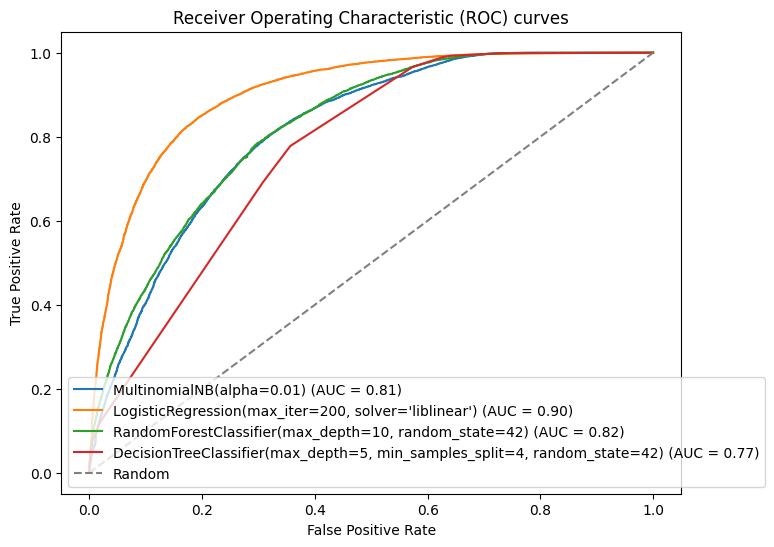

In [50]:
emb = CountVectorizer( 
        tokenizer=word_tokenize, 
        token_pattern=None
    )
train_model(model_list,emb,train_df,test_df)

model: MultinomialNB(alpha=0.01)
Accuracy = 0.75165
F1 Score = 0.7715586625580646

model: LogisticRegression(max_iter=200, solver='liblinear')
Accuracy = 0.824975
F1 Score = 0.8290395838929453

model: RandomForestClassifier(max_depth=10, random_state=42)
Accuracy = 0.7403
F1 Score = 0.7758501639910238

model: DecisionTreeClassifier(max_depth=5, min_samples_split=4, random_state=42)
Accuracy = 0.710675
F1 Score = 0.7293561890507706



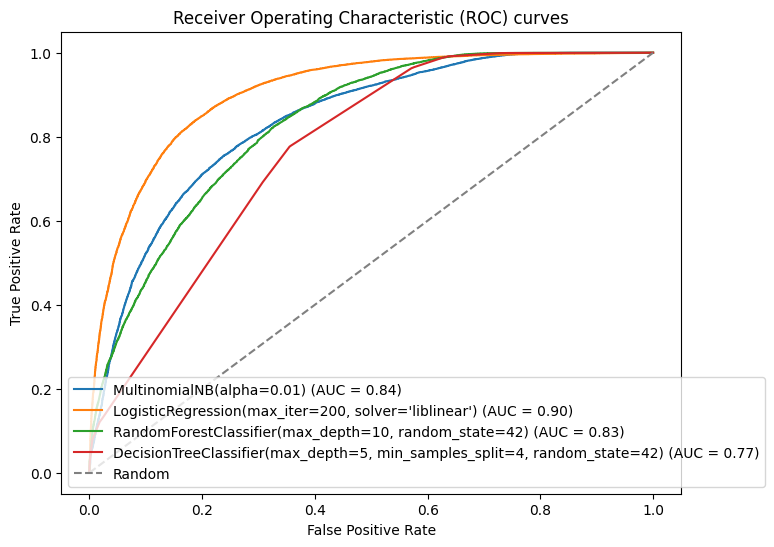

In [51]:
emb = TfidfVectorizer( 
        tokenizer=word_tokenize, 
        token_pattern=None
    )
train_model(model_list,emb,train_df,test_df)

In [52]:
def pad_sequences(vectors, maxlen, dtype='float32'):
    """Pads sequences of word vectors to the same length with zero vectors."""
    # The padding value is a vector of zeros with the same width as the embeddings
    padding_value = np.zeros_like(vectors[0][0], dtype=dtype)
    
    for i in range(len(vectors)):
        print(vectors[i].shape)

    if(len(vectors[0].shape) == 1):
        padded_sequences = np.zeros((len(vectors), maxlen), dtype=dtype)
    else:
        padded_sequences = np.zeros((len(vectors), maxlen, vectors[0].shape[1]), dtype=dtype)
    
    for i, sequence in enumerate(vectors):
        for j, vector in enumerate(sequence):
            if j < maxlen:
                padded_sequences[i, j] = vector
                
    return padded_sequences

def handle_uneven_sequences(sequences, maxlen=None, dtype='float32'):
    """Pads or truncates sequences of word vectors to the same length."""
    # If maxlen is not provided, use the length of the longest sequence
    if maxlen is None:
        if not isinstance(sequences[0], list):
            maxlen = max([sequence.shape[0] for sequence in sequences])
        else:
            maxlen = max([len(sequence) for sequence in sequences])
    
    padded_sequences = pad_sequences(sequences, maxlen, dtype=dtype)
    
    return padded_sequences

(54, 20)
(61, 20)
(21, 20)
(9, 20)
(90, 20)
(43, 20)
(69, 20)
(59, 20)
(76, 20)
(57, 20)
(34, 20)
(45, 20)
(20, 20)
(52, 20)
(112, 20)
(97, 20)
(48, 20)
(10, 20)
(124, 20)
(50, 20)
(78, 20)
(39, 20)
(129, 20)
(44, 20)
(52, 20)
(116, 20)
(67, 20)
(25, 20)
(115, 20)
(25, 20)
(39, 20)
(88, 20)
(73, 20)
(100, 20)
(86, 20)
(48, 20)
(68, 20)
(77, 20)
(68, 20)
(119, 20)
(30, 20)
(47, 20)
(44, 20)
(76, 20)
(127, 20)
(62, 20)
(67, 20)
(50, 20)
(113, 20)
(40, 20)
(47, 20)
(86, 20)
(78, 20)
(32, 20)
(70, 20)
(37, 20)
(26, 20)
(69, 20)
(41, 20)
(90, 20)
(118, 20)
(55, 20)
(109, 20)
(115, 20)
(44, 20)
(27, 20)
(123, 20)
(105, 20)
(20, 20)
(33, 20)
(48, 20)
(40, 20)
(50, 20)
(114, 20)
(28, 20)
(10, 20)
(112, 20)
(85, 20)
(77, 20)
(22, 20)
(69, 20)
(123, 20)
(106, 20)
(70, 20)
(46, 20)
(60, 20)
(71, 20)
(117, 20)
(32, 20)
(22, 20)
(32, 20)
(63, 20)
(107, 20)
(121, 20)
(40, 20)
(60, 20)
(94, 20)
(111, 20)
(22, 20)
(116, 20)
(62, 20)
(123, 20)
(57, 20)
(92, 20)
(41, 20)
(118, 20)
(113, 20)
(94, 20)
(88

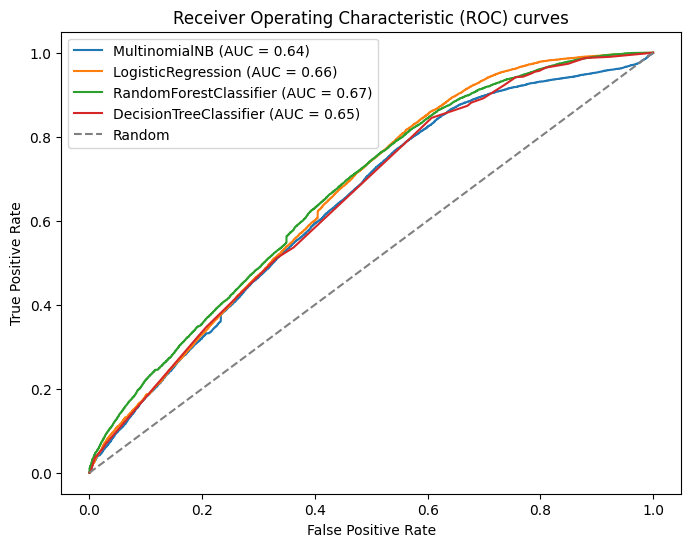

In [57]:
from vectorization import glove


def train_model_with_glove(models, train_df, test_df):
    plt.figure(figsize=(8, 6))
    
    x_train =[glove(text) for text in train_df.text]
    x_test = [glove(text) for text in test_df.text]

    # Pad the sequences to the same length
    x_train_padded = handle_uneven_sequences(x_train)
    x_test_padded = handle_uneven_sequences(x_test)

    x_train = np.mean(np.array(x_train_padded), axis=1)
    x_test = np.mean(np.array(x_test_padded), axis=1)


    for this_model in models:
        xtrain = x_train
        xtest = x_test
        if type(this_model).__name__ == "MultinomialNB":
            # Naive Bayes expects non-negative inputs
            scaler = MinMaxScaler()

            xtrain = scaler.fit_transform(xtrain)
            xtest = scaler.transform(xtest)
        model = this_model
        model.fit(xtrain, train_df.sentiment)
        pred_probs = model.predict_proba(xtest)[:, 1]
        fpr, tpr, thresholds = roc_curve(test_df.sentiment, pred_probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{type(this_model).__name__} (AUC = {roc_auc:.2f})')
        
        preds = model.predict(xtest)
        accuracy = accuracy_score(test_df.sentiment, preds)
        f1 = f1_score(test_df.sentiment, preds)
        
        print("model:", type(this_model).__name__)
        print(f"Accuracy = {accuracy}")
        print(f"F1 Score = {f1}")
        print("")
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) curves')
    plt.legend()
    plt.show()

train_model_with_glove(model_list, train_df, test_df)

# create a sbumission

In [54]:
# load and do the same preprocessing for the test data 
with open('./data/test_data.txt', 'r') as file:
    test_data = file.readlines()
test_data = [remove_patterns(tweet.rstrip('\n')) for tweet in test_data]
test_df = pd.DataFrame({'text': test_data})

with open('count_vectorizer.pkl', 'rb') as file:
    count_vec = pickle.load(file)
test = count_vec.transform(test_df.text) 

# load the model and predict
with open('naive_lr.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

predicted = loaded_model.predict(test)
submission = pd.DataFrame({'Id':range(1, len(test_data) + 1),'Prediction': predicted})
submission.to_csv('submission.csv', index=False) 

FileNotFoundError: [Errno 2] No such file or directory: 'count_vectorizer.pkl'

# TF-IDF with N-gram

In [ ]:
emb = TfidfVectorizer(
        tokenizer=word_tokenize, 
        token_pattern=None, 
        ngram_range=(1, 3)
    )
train_model(model_list,emb,train_df,test_df)

c:\Users\Welkin\AppData\Local\anaconda3\envs\ada\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold: 0
Accuracy = 0.83655

Fold: 1
Accuracy = 0.8392

Fold: 2
Accuracy = 0.836175



c:\Users\Welkin\AppData\Local\anaconda3\envs\ada\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# load and do the same preprocessing for the test data 
with open('./data/test_data.txt', 'r') as file:
    test_data = file.readlines()
test_data = [remove_patterns(tweet.rstrip('\n')) for tweet in test_data]
test_df = pd.DataFrame({'text': test_data})

with open('tfid.pkl', 'rb') as file:
    tfidf_vec = pickle.load(file)
test = tfidf_vec.transform(test_df.text) 

# load the model and predict
with open('tfidf.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

predicted = loaded_model.predict(test)
submission = pd.DataFrame({'Id':range(1, len(test_data) + 1),'Prediction': predicted})
submission.to_csv('tf_submission.csv', index=False) 